<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/H2H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ansonkwokth/TableTennisPrediction.git
%cd TableTennisPrediction

Cloning into 'TableTennisPrediction'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 265 (delta 64), reused 15 (delta 15), pack-reused 161 (from 1)
Receiving objects: 100% (265/265), 3.59 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/TableTennisPrediction


In [3]:
import pandas as pd
from tabulate import tabulate
from utils import data_loader as dl

import numpy as np
from model.Elo import Elo
from model.ModifiedElo import ModifiedElo
from model.ensemble import BaggingRatingSystem

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import copy

import warnings
warnings.filterwarnings('ignore')

# Data

In [4]:
# GAME = 'TTStar'
# GAME = 'TTCup'
# GAME = 'SetkaCup'
GAME = 'SetkaCupWomen'
# GAME = 'LigaPro'


In [5]:
match GAME:
    case 'TTStar':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'TTCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCupWomen':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'LigaPro':
        years = [2022, 2023, 2024]
    case _:
        raise ValueError("Invalid game selected.")


text_data_game = dl.load_game_data(GAME, years, '../')
text_data = {
    year: text_data_game[year] for year in years
}
df = dl.create_game_dfs(GAME, years, text_data)

Loading ..//SetkaCupWomen2020.txt
Loading ..//SetkaCupWomen2021.txt
Loading ..//SetkaCupWomen2022.txt
Loading ..//SetkaCupWomen2023.txt
Loading ..//SetkaCupWomen2024.txt


In [6]:
# Generate ID indices for each pair of rows in the DataFrame
idx_lt = [i for i in range(len(df) // 2) for _ in range(2)]
df['ID'] = idx_lt  # Assign to the 'ID' column

# Reset the DataFrame index to ensure it's sequential
df.reset_index(drop=True, inplace=True)

# Get unique players and store them in player_lt
player_lt = df['Player'].unique()



In [7]:
year_val = years[-2]
year_test = years[-1]


df = df.sort_values(['ID', 'Player'])
df_train = df.loc[pd.DatetimeIndex(df['Date']).year < year_val]
df_val = df.loc[pd.DatetimeIndex(df['Date']).year == year_val]
df_test = df.loc[pd.DatetimeIndex(df['Date']).year == year_test]


In [8]:
def format_to_array(df: pd.DataFrame) -> np.ndarray:

    # info_col = ['ID', 'Round', 'Datetime', 'Game', 'Date', 'Time']
    info_col = ['Round', 'Datetime', 'Game', 'Date', 'Time']
    col = [item for item in df.columns if item not in info_col]

    df[[c for c in col if "Set" in c]] = df[[c for c in col if "Set" in c]].astype(float)
    X = df[col].values.reshape(-1, 2, len(col))
    return X

In [9]:
X_train = format_to_array(df_train)
X_val = format_to_array(df_val)
X_test = format_to_array(df_test)

In [10]:
X_all = format_to_array(df)

In [11]:
modelMElo = ModifiedElo()

# traing model with only training set
for _ in range(5):
    modelMElo.fit(X_train)


Training model: 100%|██████████| 26120/26120 [00:01<00:00, 15728.03it/s]


# H2H histroy

In [12]:
class SymmetricTable:
    def __init__(self):
        self.data = {}

    def add(self, key1, key2, value):
        """Append value to the list corresponding to the symmetric key."""
        key = tuple(sorted([key1, key2]))
        if key not in self.data:
            self.data[key] = []
        self.data[key].append(value)

    def get(self, key1, key2):
        """Retrieve the list of values for the given symmetric key, defaulting to an empty list."""
        return self.data.get(tuple(sorted([key1, key2])), [])





# Id and the corresponding past h2h history before this match
h2h_rate = {}
table = SymmetricTable()
SETCOL = [i for i in df_train.columns if 'Set' in i]


for id in tqdm(df.ID.unique()):
    df_i = df[df.ID == id]

    player1, player2 = df_i.Player.values
    # all the historical sets
    histo_rate = table.get(player1, player2)
    # the mean of the win rate
    histo_rate_mean = np.mean(histo_rate)
    # add to the dict
    h2h_rate[id] = histo_rate_mean

    df_p_i = df_i.sort_values("Player")
    # the scores of the sets
    scores = df_p_i[SETCOL].values
    winrate_i = (scores[0] / (scores[0] + scores[1]))

    # add the current set results to the history
    for wi in winrate_i:
        if np.isnan(wi): continue
        table.add(player1, player2, wi)


100%|██████████| 34579/34579 [00:52<00:00, 658.63it/s]


# Look at the relation

In [ ]:
def evaluate_point(model, dataset, h2h):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False

    history = []
    predictions = []
    h2hs = []
    for idx, matchi in tqdm(enumerate(dataset), desc="Evaluating matches"):
        id = matchi[0, 0]
        matchi = matchi.T
        h2hi = h2h[id]
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue

        for seti in matchi[2:]:
            if np.isnan(seti[0]) or (seti[0] + seti[1]) == 0: break
            winrate = seti[0] / (seti[0] + seti[1])
            history.append(winrate)
            predictions.append(p)
            h2hs.append(h2hi)


    return np.array(history), np.array(predictions), np.array(h2hs)



In [ ]:
hist, pred, h2h = evaluate_point(modelMElo, X_train, h2h_rate)
# hist, pred, h2h = evaluate_point(modelMElo, X_val, h2h_rate)
# hist, pred, h2h = evaluate_point(modelMElo, X_test, h2h_rate)
# hist, pred = evaluate_point(modelMElo, X_val)

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 26120it [00:00, 38202.89it/s]


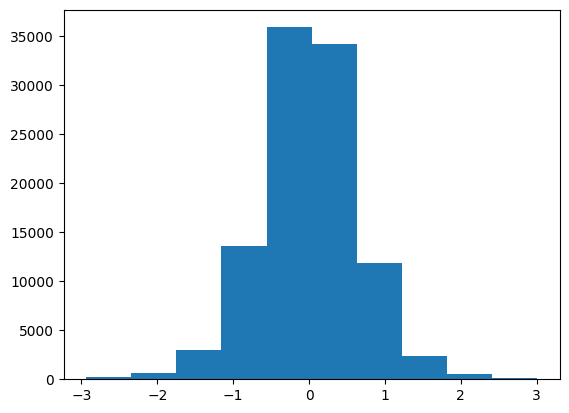

In [ ]:
logit_hist = np.log(hist / (1-hist))
logit_pred = np.log(pred / (1-pred))
residul = logit_hist - logit_pred
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul);


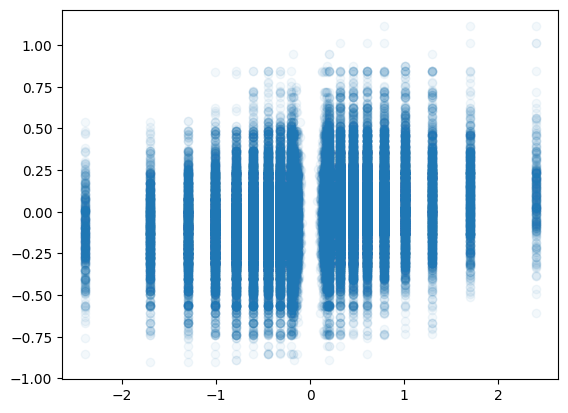

In [ ]:
plt.scatter(logit_hist, logit_pred, alpha=0.05)



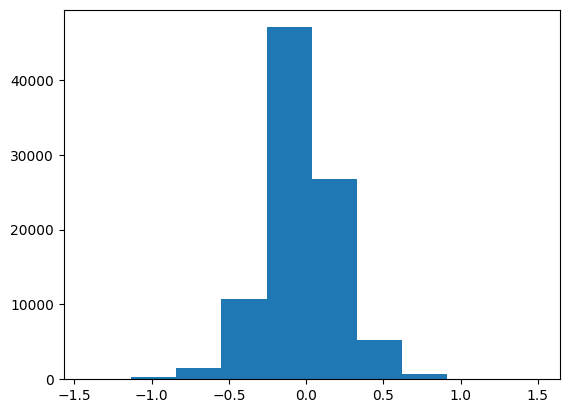

In [ ]:
logit_h2h = np.log(h2h / (1-h2h))
logit_h2h = np.nan_to_num(logit_h2h, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(logit_h2h);


$\hat{y}=\frac{1}{1+\exp{(-x)}}$

$\hat{y}^{(0)}=\frac{1}{1+\exp{(-\Delta S)}}$, $\Delta S\equiv S_1 - S_2$

$\hat{x}^{(1)}=\Delta S + \epsilon_{\rm H}\Delta H$

Fir the residual:

$R\equiv x - \Delta S = \epsilon_{\rm H}\Delta H$.

After fitting the $\hat{\epsilon}_{\rm H}$, then do $\hat{x}^{(1)} = \Delta S + \hat{\epsilon}_{\rm H}\Delta H$

In [ ]:

comb = np.array([logit_h2h, residul])

comb = comb[:, ~(abs(comb)<=1e-10).any(axis=0)]
comb = comb[:, ~(abs(comb)>=1e10).any(axis=0)]
comb = comb[:, ~np.any(np.isnan(comb), axis=0)]

Text(0, 0.5, '$R$')

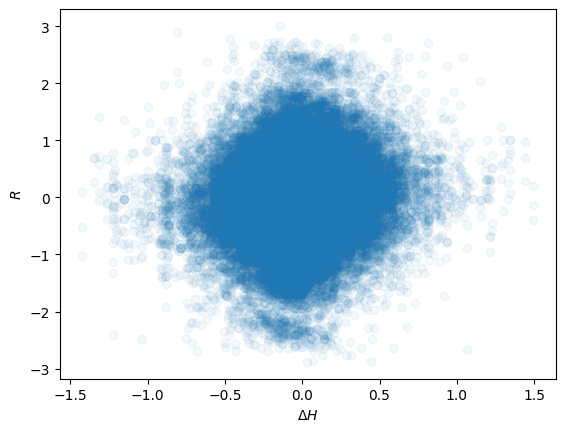

In [ ]:
plt.scatter(comb[0], comb[1], alpha=0.05)
plt.xlabel("$\Delta H$")
plt.ylabel("$R$")


In [ ]:
import statsmodels.api as sm
x = comb[0]    # Delta H
y = comb[1].reshape(-1, 1)    # Residual
ols = sm.OLS(y, x)
ols_result = ols.fit()
print(ols_result.summary())
eps = ols_result.params[0]
eps

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              766.5
Date:                Wed, 12 Feb 2025   Prob (F-statistic):                   5.00e-168
Time:                        22:12:32   Log-Likelihood:                         -89806.
No. Observations:               92304   AIC:                                  1.796e+05
Df Residuals:                   92303   BIC:                                  1.796e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

0.23982140578008834

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)
reg.coef_


array([[0.24376928]])

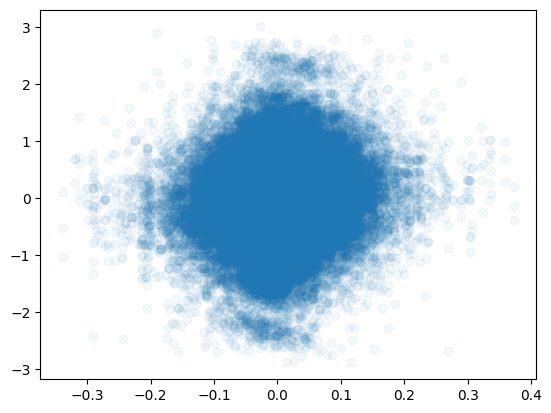

In [ ]:

plt.scatter(reg.predict(x.reshape(-1, 1)), y, alpha=0.05)
# plt.scatter(x, y, alpha=0.05)

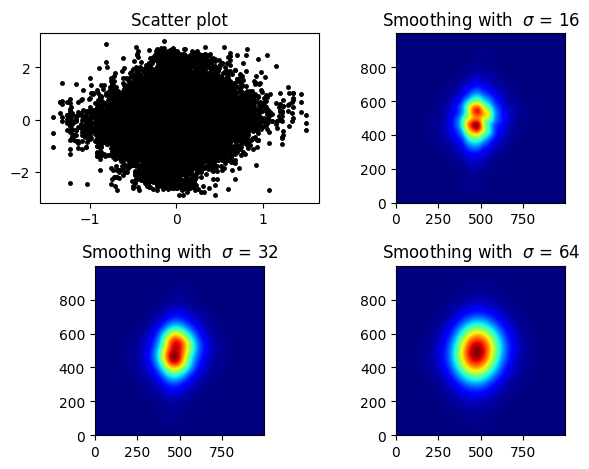

In [ ]:
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x, y = comb[0], comb[1]

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.tight_layout()
plt.show()

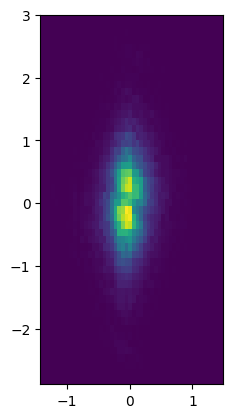

In [ ]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

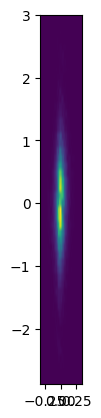

In [ ]:
eps = 0.23
y_rot = logit_pred + eps*logit_h2h
comb_rot = np.array([y_rot, logit_hist])

y_rot = eps*logit_h2h
comb_rot = np.array([y_rot, residul])

comb_rot = comb_rot[:, ~(abs(comb_rot)<=1e-10).any(axis=0)]
comb_rot = comb_rot[:, ~(abs(comb_rot)>=1e10).any(axis=0)]
comb_rot = comb_rot[:, ~np.any(np.isnan(comb_rot), axis=0)]


heatmap, xedges, yedges = np.histogram2d(comb_rot[0], comb_rot[1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [ ]:
y_rot = reg.predict(np.nan_to_num(logit_h2h.reshape(-1, 1), 0)).reshape(1, -1)[0] + logit_pred
pred_1 = 1 / (1 + np.exp(-y_rot))


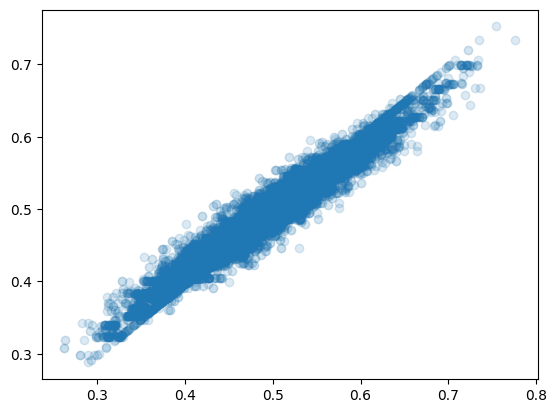

In [ ]:
plt.scatter(pred_1, pred, alpha=0.05)

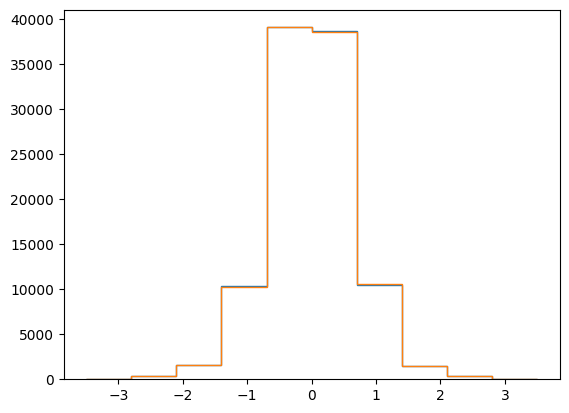

In [ ]:
logit_hist = np.log(hist / (1-hist))

residul = logit_hist - y_rot
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul, histtype='step', range=[-3.5, 3.5], bins=10);

logit_hist = np.log(hist / (1-hist))
logit_pred = np.log(pred / (1-pred))
residul = logit_hist - logit_pred
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul, histtype='step', range=[-3.5, 3.5], bins=10);


In [ ]:
sum(np.round(hist) == np.round(pred)) / len(hist)

0.5899593845192533

In [ ]:
sum(np.round(hist) == np.round(y_rot.reshape(1, -1)[0])) / len(hist)

0.5070784191205187

# New Model with H2H

In [36]:
import numpy as np
from tqdm import tqdm
from math import comb



class RatingSystem:

    def __init__(self, learning_rate=32, binary=False, verbose=False):

        if not isinstance(learning_rate, (float, int)):
            raise TypeError(f"Expected 'learning_rate' to be an float/int, but got {type(learning_rate).__name__}")
        if learning_rate <= 0:
            raise ValueError(f"Expected 'learning_rate' to be positive, but got {learning_rate}")

        if not isinstance(verbose, bool):
            raise TypeError(f"Expected 'verbose' to be an bool, but got {type(verbose).__name__}")

        self.params = {}
        self.learning_rate = learning_rate
        self.binary = binary
        self.verbose = verbose

        self._found_p1 = None
        self._found_p2 = None



    @staticmethod
    def _add_sigma(sigma1, sigma2):
        return np.sqrt(sigma1**2 + sigma2**2)



    @staticmethod
    def predict_set_config_from_p(p):
        q = 1 - p
        dt = {}
        # Calculate probabilities for the first 10+ points won by player 1
        for i in range(10):
            prob = comb(10 + i, 10) * p**11 * q**i
            dt[10 + i + 1] = prob  # Store probability for player 1 winning 11, 12, ... points
        # Calculate probability for the special case of winning exactly 22 points
        dt[22] = (1 / (1 - 2 * q * p)) * comb(20, 10) * p**12 * q**10
        return dt



    @staticmethod
    def predict_game_config_from_p(p, n_win_sets=3):
        # Ensure n_win_sets is odd
        if n_win_sets % 2 == 0:
            raise ValueError("'n_win_sets' must be an odd number.")
        q = 1 - p
        dt = {}
        # Calculate probabilities for winning n_win_sets, n_win_sets+1, ...
        for i in range(n_win_sets):
            prob = comb(n_win_sets - 1 + i, n_win_sets - 1) * p**n_win_sets * q**i
            dt[n_win_sets + i] = prob  # Store probability for winning sets
        return dt



    def get_player_param(self, player):
        return self._get_player_param(player)



    def _predict_point(self, player1, player2):
        """
        Predict the probability of Player 1 winning a point against Player 2.

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: Probability of Player 1 winning a point.
        """
        self._prediction_verbose(player1, player1)
        self._found_p1, param1 = self._get_player_param(player1)
        self._found_p2, param2 = self._get_player_param(player2)
        return self._expected_prob(param1, param2)


    def predict_point(self, player1, player2):
        p = self._predict_point(player1, player2)
        return self._found_p1, self._found_p2, p


    def predict_set_config(self, player1, player2):
        """
        Predict the probability of Player 1 winning a set against Player 2,
        with total points being 'n', in the set.
        For each possible 'n', calculate the corresponding prob.

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: dict of probabilities of Player 1 winning the set with total 'n' points.
        """
        ps = self.predict_set_config_from_p(self._predict_point(player1, player2))
        return self._found_p1, self._found_p2, ps


    def predict_set(self, player1, player2):
        """
        Predict the probability of Player 1 winning a set against Player 2,

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: Probability of Player 1 winning the set
        """
        _, _, ps = self.predict_set_config(player1, player2)
        return self._found_p1, self._found_p2, sum(ps.values())


    def predict_game_config(self, player1, player2, n_win_sets=3):
        """
        Predict the probability of Player 1 winning the game against Player 2,
        with total number of sets being 'n', in the game.
        For each possible 'n', calculate the corresponding prob.

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :param n_win_sets: Number of winning sets to win the game
        :return: dict of probabilities of Player 1 winning the game with total 'n' sets.
        """
        _, _, p_set = self.predict_set(player1, player2)
        p = self.predict_game_config_from_p(p_set, n_win_sets)
        return self._found_p1, self._found_p2, p


    def predict_game(self, player1, player2):
        """
        Predict the probability of Player 1 winning the game against Player 2,

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: Probability of Player 1 winning the game
        """
        _, _, ps = self.predict_game_config(player1, player2)
        return self._found_p1, self._found_p2, sum(ps.values())



    def fit(self, dataset, features=None):
        """
        Fit the model to a dataset of matches.

        :param dataset: an array with shape (m, 2, s)
                        with m = number of matches
                             2 = 1v1
                             s = max number of sets in the dataset
                        Note that it must be sorted with time
                        for example:
                        array([[['Reitspies D.', 11.0, 11.0, ..., nan, nan, nan],
                                ['Gavlas A.', 9.0, 9.0, ..., nan, nan, nan]],

                            [['Kleprlik J.', 3.0, 4.0, ..., nan, nan, nan],
                                ['Prokopcov D.', 11.0, 11.0, ..., nan, nan, nan]],

                            [['Horejsi M.', 11.0, 11.0, ..., 7.0, 9.0, nan],
                                ['Tregler T.', 4.0, 8.0, ..., 11.0, 11.0, nan]],
        """
        # loop over matches
        for matchi in tqdm(dataset, desc="Training model"):
            matchi = matchi.T
            # the first row are the players
            player1, player2 = matchi[1]

            match_id = matchi[0, 0]
            featuresi = features[match_id]

            # loop over sets in the match
            for seti in matchi[2:]:
                points1, points2 = seti
                # skip nan entries
                if np.isnan(points1) or np.isnan(points2): continue
                # skip total points = 0
                points_sum = points1 + points2
                if points_sum == 0: continue

                result1 = points1 / points_sum
                if self.binary: result1 = result1 = 1 if result1 > 0.5 else 0

                # Add players to the system if they are not already in
                self._add_player(player1)
                self._add_player(player2)

                # Update ratings based on the match result
                self._update_params(player1, player2, result1, featuresi)





In [76]:


class ModifiedEloH2H(RatingSystem):
    def __init__(self, learning_rate=0.1, base_param=(0, 1), eps_h2h=0.1, update_sigma=True, binary=False, verbose=False):
        """
        Initialize the rating system.

        :param learning_rate: Learning rate.
        :param params: Parameters for the players.
        :param update_sigma: Update also sigma during the gradient descent.
        """
        super().__init__(learning_rate=learning_rate, binary=binary, verbose=verbose)

        if not isinstance(base_param, tuple):
            raise TypeError(f"Expected 'base_param' to be a tuple, but got {type(base_param).__name__}")
        if len(base_param) != 2:
            raise ValueError(f"Expected 'value' to be a 2-entry tuple, but got {len(base_param)} entries")
        if not all(isinstance(entry, (int, float)) for entry in base_param):
            raise TypeError("Both entries in 'base_param' must be float/int")
        if base_param[1] <= 0:
            raise ValueError(f"The second entry in 'base_param' must be greater than 0, but got {base_param[1]}")

        if not isinstance(update_sigma, bool):
            raise TypeError(f"Expected 'update_sigma' to be an bool, but got {type(update_sigma).__name__}")

        self.params = {}
        self.eps_h2h = eps_h2h
        self.base_param = base_param
        self.update_sigma = update_sigma



    def __repr__(self):
        return f"ModifiedEloH2H(learning_rate={self.learning_rate}, base_param={self.base_param}, eps_h2h={self.eps_h2h}, update_sigma={self.update_sigma}, verbose={self.verbose})"






    def _get_player_param(self, player):
        """
        Retrieve the current rating of a player. If the player does not exist, use the default.

        :param player: The player's name.
        :return: Current rating of the player.
        """
        return (player in self.params), self.params.get(player, self.base_param)




    def _expected_prob(self, param1, param2, logit_h2h):
        """
        Calculate the expected prob. of winning a point.

        :param param1: Parameters of Player 1.
        :param param2: Parameters of Player 2.
        :return: Expected prob for Player 1.
        """
        # Calculate the combined sigma and the difference in mu values
        z = (param1[0] - param2[0]) / self._add_sigma(param1[1], param2[1]) + self.eps_h2h * logit_h2h
        # Calculate the predicted probability using the logistic function
        return 1 / (1 + np.exp(-z))



    def _prediction_verbose(self, player1, player2):
        if self.verbose:
            for player in (player1, player2):
                if player not in self.params:
                    print(f'Player "{player}" not found. Initialize param: {self.base_param}')



    def _add_player(self, player, param=None):
        """
        Add a new player with an optional custom param.

        :param player: Name of the player.
        :param rating: Custom initial rating (defaults to base_rating if not provided).
        """
        if player not in self.params:
            self.params[player] = param if param is not None else self.base_param



    def display_params(self, round_digits=2, first_n=None):
        """
        Display the current ratings of all players, rounded to the specified number of digits.

        :param round_digits: Number of decimal places to round the parameters. Default is 2.
        :param first_n: If specified, only display the top `first_n` players based on their ratings.
        """
        # Sort players by the first element of their parameter tuple in descending order
        sorted_params = sorted(self.params.items(), key=lambda x: x[1][0], reverse=True)

        # Limit the list to the first `first_n` players if specified
        if first_n is not None:
            sorted_params = sorted_params[:first_n]

        # Display the parameters
        for player, param in sorted_params:
            rounded_param = tuple(round(value, round_digits) for value in param)
            print(f"{player}: {rounded_param}")



    def _update_params(self, player1, player2, result1, h2h):
        """
        Update ratings for two players after a match.

        :param player1: Name or identifier of Player 1.
        :param player2: Name or identifier of Player 2.
        :param result1: Result for Player 1 (points1 / points_tot).
        """
        found_p1, param1 = self.get_player_param(player1)
        found_p2, param2 = self.get_player_param(player2)


        logit_h2h = np.log(h2h / (1-h2h))
        expected1 = self._expected_prob(param1, param2, logit_h2h)
        mu_diff = param1[0] - param2[0]
        sigma_tot = self._add_sigma(param1[1], param2[1])

        # Calculate updates
        mu1_update = (expected1 - result1) / sigma_tot
        mu2_update = - (expected1 - result1) / sigma_tot
        sigma1_update = sigma2_update = 0
        if self.update_sigma:
            sigma1_update = (-mu_diff * param1[1]) / sigma_tot**3 * (expected1 - result1)
            sigma2_update = (-mu_diff * param2[1]) / sigma_tot**3 * (expected1 - result1)

        # Update ratings and assign new tuples
        self.params[player1] = (
            param1[0] - self.learning_rate * mu1_update,
            param1[1] - self.learning_rate * sigma1_update
        )
        self.params[player2] = (
            param2[0] - self.learning_rate * mu2_update,
            param2[1] - self.learning_rate * sigma2_update
        )
        self.eps_h2h = self.eps_h2h - self.learning_rate * (expected1 - result1) * logit_h2h




    def _predict_point(self, player1, player2, h2h):
        """
        Predict the probability of Player 1 winning a point against Player 2.

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: Probability of Player 1 winning a point.
        """
        self._prediction_verbose(player1, player1)
        self._found_p1, param1 = self._get_player_param(player1)
        self._found_p2, param2 = self._get_player_param(player2)
        logit_h2h = np.log(h2h / (1-h2h))
        return self._expected_prob(param1, param2, logit_h2h)


    def predict_point(self, player1, player2, h2h):
        p = self._predict_point(player1, player2, h2h)
        return self._found_p1, self._found_p2, p




In [117]:
h2h_train = {}
for id in tqdm(df_train.ID.unique()):
    h2h_train[id] = np.nan_to_num(h2h_rate[id], nan=0.5)

h2h_val = {}
for id in tqdm(df_val.ID.unique()):
    h2h_val[id] = np.nan_to_num(h2h_rate[id], nan=0.5)

h2h_test = {}
for id in tqdm(df_test.ID.unique()):
    h2h_test[id] = np.nan_to_num(h2h_rate[id], nan=0.5)

100%|██████████| 1969/1969 [00:00<00:00, 14885.13it/s]


In [77]:
modelMEloH2H = ModifiedEloH2H()

# traing model with only training set
for _ in range(5):
    modelMEloH2H.fit(X_train, h2h_train)


Training model: 100%|██████████| 26120/26120 [00:01<00:00, 16350.63it/s]


In [98]:
modelMElo = ModifiedElo()

# traing model with only training set
for _ in range(5):
    modelMElo.fit(X_train)


Training model: 100%|██████████| 26120/26120 [00:01<00:00, 18694.53it/s]


In [79]:
modelMEloH2H.eps_h2h

0.2833201839068172

In [99]:
def evaluate(model, dataset):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False
    correct = 0
    n_matches = 0

    history = []
    predictions = []
    for matchi in tqdm(dataset, desc="Evaluating matches"):
        matchi = matchi.T
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        win1 = sum(matchi[2:, 0]>matchi[2:, 1])
        win2 = sum(matchi[2:, 0]<matchi[2:, 1])
        whowon = 0 if win1 > win2 else 1

        history.append(win1/(win1 + win2))
        predictions.append(p)

        n_matches += 1
        if (whowon == whowillwin): correct += 1

    acc = correct / n_matches
    print(f'\n === Accuracy: {acc} === \n\n')
    return acc, np.array(history), np.array(predictions)


In [103]:
def evaluateH2H(model, dataset, h2h):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False
    correct = 0
    n_matches = 0

    history = []
    predictions = []
    for matchi in tqdm(dataset, desc="Evaluating matches"):
        matchi = matchi.T
        h2hi = h2h[matchi[0, 0]]
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2, h2hi)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        win1 = sum(matchi[2:, 0]>matchi[2:, 1])
        win2 = sum(matchi[2:, 0]<matchi[2:, 1])
        whowon = 0 if win1 > win2 else 1


        history.append(win1/(win1 + win2))
        predictions.append(p)

        n_matches += 1
        if (whowon == whowillwin): correct += 1

    acc = correct / n_matches
    print(f'\n === Accuracy: {acc} === \n\n')
    return acc, np.array(history), np.array(predictions)


In [106]:
acc_h2h, hist_h2h, pred_h2h = evaluateH2H(modelMEloH2H, X_train, h2h_train);

Evaluate model: ModifiedEloH2H(learning_rate=0.1, base_param=(0, 1), eps_h2h=0.2833201839068172, update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:02<00:00, 12302.55it/s]


 === Accuracy: 0.6666539050535988 === 




In [107]:
acc, hist, pred = evaluate(modelMElo, X_train);

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:01<00:00, 19403.90it/s]


 === Accuracy: 0.6505359877488515 === 




In [115]:
acc_h2h, hist_h2h, pred_h2h = evaluateH2H(modelMEloH2H, X_val, h2h_val);

Evaluate model: ModifiedEloH2H(learning_rate=0.1, base_param=(0, 1), eps_h2h=0.2833201839068172, update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 11158.14it/s]


 === Accuracy: 0.6031143182681352 === 




In [116]:
acc, hist, pred = evaluate(modelMElo, X_val);

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 23677.94it/s]


 === Accuracy: 0.5928598556779339 === 




In [118]:
acc_h2h, hist_h2h, pred_h2h = evaluateH2H(modelMEloH2H, X_test, h2h_test);

Evaluate model: ModifiedEloH2H(learning_rate=0.1, base_param=(0, 1), eps_h2h=0.2833201839068172, update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 1969/1969 [00:00<00:00, 3866.02it/s]


 === Accuracy: 0.6070889894419306 === 




In [119]:
acc, hist, pred = evaluate(modelMElo, X_test);

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 1969/1969 [00:00<00:00, 55272.42it/s]


 === Accuracy: 0.583710407239819 === 


